In [ ]:
# If using colab 
# !pip install "pyGTFSHandler[osm,plot] @ git+https://github.com/CityScope/pyGTFSHandler.git"
# !pip install matplotlib mapclassify folium

In [2]:
import os

from pyGTFSHandler.feed import Feed
from pyGTFSHandler.downloaders.mobility_database import MobilityDatabaseClient
from pyGTFSHandler.utils import get_geographic_suggestions_from_string
from pyGTFSHandler.utils import get_city_geometry
import pyGTFSHandler.plot_helper as plot_helper
import pyGTFSHandler.gtfs_checker as gtfs_checker
import pyGTFSHandler.processing_helper as processing_helper
from datetime import datetime, date, timedelta, time
import pandas as pd
import polars as pl 
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

In [3]:
def df_to_stop_gdf(df):
    if isinstance(df,pl.LazyFrame):
        df = df.collect()
    if isinstance(df, pl.DataFrame):
        df = df.to_pandas()

    df = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df['stop_lon'],df['stop_lat']),crs=4326)
    return df 

In [4]:
city_name = "Cambridge, Massachusetts, USA"
download_buffer = 2000 # In meters

In [5]:
# Name of the folder with results
city_filename = gtfs_checker.normalize_string(city_name)

# Area of interest as a Polygon
aoi = get_city_geometry(city_name)

# Area used for downloading data
aoi_download = aoi.to_crs(aoi.estimate_utm_crs()).buffer(download_buffer)

# Country, State and Municipality of your AOI
geo_suggestions = get_geographic_suggestions_from_string(city_name)

geo_suggestions

{'country_codes': ['US'],
 'subdivision_names': ['Massachusetts', 'Middlesex County'],
 'municipalities': ['Cambridge', 'Middlesex County']}

In [6]:
# Save all files in a dir with the name of the city
os.makedirs(city_filename,exist_ok=True)

In [ ]:
# Request your refresh token here: https://mobilitydatabase.org/ 
refresh_token = ''
api = MobilityDatabaseClient(refresh_token)

2025-11-16 20:06:37,037 - INFO - Obtaining or refreshing access token...
2025-11-16 20:06:38,873 - INFO - Access token obtained successfully.


#### Search feeds

In [8]:
feeds = api.search_gtfs_feeds(
    country_code=geo_suggestions['country_codes'],
    # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    subdivision_name=geo_suggestions['subdivision_names'],
    # This info is not always in the feeds metadata. Comment this if you did not find all feeds.
    municipality=geo_suggestions['municipalities'],
    # Set to True if you only want official feeds
    # is_official=True, 
    # You could comment the rest of search args and use only aoi
    # Sometimes the API seems to not do this very well as the metadata is often wrong.
    # aoi=aoi_download, 
)

for f in feeds:
    print(f['provider'])

2025-11-16 20:06:38,879 - INFO - Searching with params: {'country_code': 'US', 'subdivision_name': 'Massachusetts', 'municipality': 'Cambridge'}
2025-11-16 20:06:39,044 - INFO - Searching with params: {'country_code': 'US', 'subdivision_name': 'Massachusetts', 'municipality': 'Middlesex County'}
2025-11-16 20:06:39,699 - INFO - Searching with params: {'country_code': 'US', 'subdivision_name': 'Middlesex County', 'municipality': 'Cambridge'}
2025-11-16 20:06:40,033 - INFO - Searching with params: {'country_code': 'US', 'subdivision_name': 'Middlesex County', 'municipality': 'Middlesex County'}
2025-11-16 20:06:40,216 - INFO - Total unique feeds found: 17


128 Business Council
Amtrak
Amtrak Vermonter
Boston Express Bus
Coach Company
Harvard University
Lexpress
Logan Express
Lowell Regional Transit Authority (LRTA)
Massachusetts Bay Transportation Authority (MBTA)
Massport
Merrimack Valley Regional Transit Authority (MVRTA)
MetroWest Regional Transit Authority (MWRTA)
Middlesex 3 TMA
Montachusett Regional Transit Authority (MART)
Peter Pan
Yankee Line


#### Download feeds

In [9]:
orig_file_paths = api.download_feeds(
    feeds=feeds,
    download_folder=city_filename+"/orig_gtfs_files",
    overwrite=False
)

2025-11-16 20:06:40,228 - INFO - Successfully downloaded 17 feeds.


In [10]:
# A) Do not fix the gtfs. Feed has a fast basic gtfs fixer but does not log all the errors.

file_paths = orig_file_paths

# B) Check and fix the gtfs files (This takes a few minutes). Set check_files = False in Feed to load faster

# file_paths = []
# for f in orig_file_paths:
#     filename = os.path.splitext(os.path.basename(f))[0]
#     if os.path.isdir(os.path.join(city_filename,"gtfs_files",filename)):
#         file_paths.append(os.path.join(city_filename,"gtfs_files",filename))
#     else:
#         file_paths.append(gtfs_checker.preprocess_gtfs(f,city_filename+"/gtfs_files"))

### Feed object

This object contains all methods you can do with the GTFS and a dataframe with all info

Any method of the Feed object return a polars dataframe. If you want the dataframe as pandas to .to_pandas()

In [11]:
gtfs = Feed(
    file_paths,
    aoi=aoi,
    # Group stops into same that are less than x meters apart. This updates the parent_station column
    stop_group_distance=100, 
    start_date=datetime(day=1,month=11,year=2025),
    end_date=datetime(day=30,month=11,year=2025),
)

/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/pyGTFSHandler/feed.py:272: UserWarning: Extracting /home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/tutorial/cambridge_massachusetts_usa/orig_gtfs_files/mdb440__128_busine.zip to /home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/tutorial/cambridge_massachusetts_usa/orig_gtfs_files/mdb440__128_busine
  warnings.warn(f"Extracting {orig_file} to {gtfs_dir[i]}")
/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/pyGTFSHandler/feed.py:272: UserWarning: Extracting /home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/tutorial/cambridge_massachusetts_usa/orig_gtfs_files/mdb11__amtrak.zip to /home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/tutorial/cambridge_massachusetts_usa/orig_gtfs_files/mdb11__amtrak
  warnings.warn(f"Extracting {orig_file} to {gtfs_dir[i]}")
/home/miguel/Documents/Proyectos/PTLevelofService/gtfs/pyGTFSHandler/pyG

### Service Intensity

This is the number of vehicles that arrive at each stop every day multiplied by the number of stops:

$\text{Service Intensity} = (\text{Number of vehicles per stop}) \times (\text{Number of stops})$

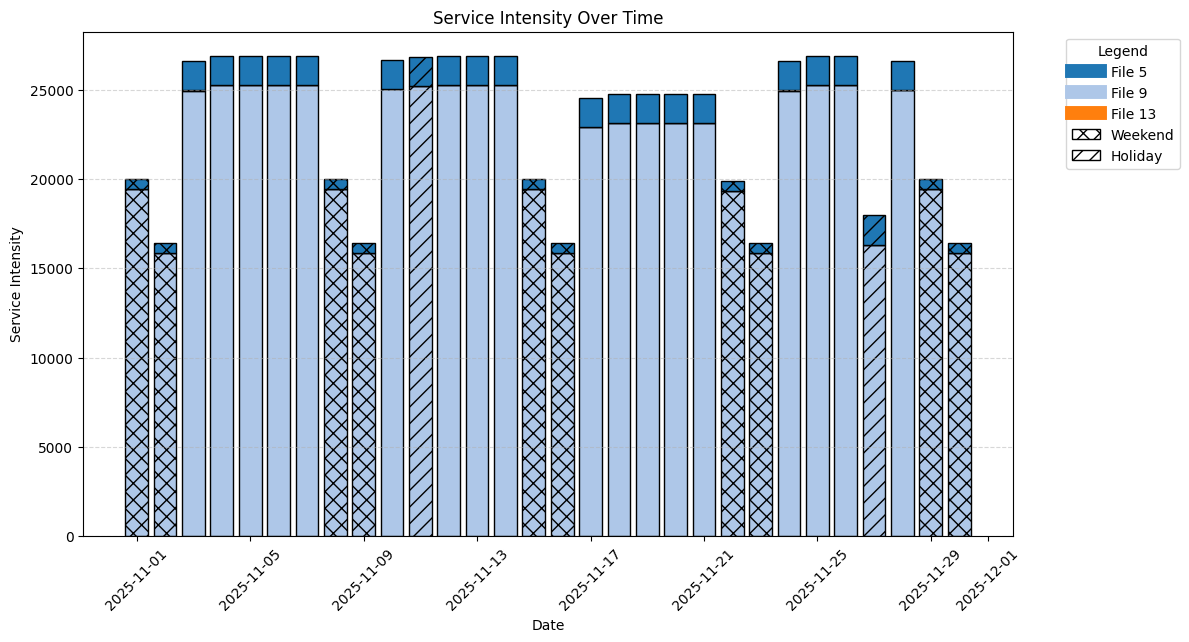

In [12]:
service_intensity = gtfs.get_service_intensity_in_date_range(
    start_date=None, # If None take the feed min date
    end_date=None, # If None take the feed max date
    date_type=None, # Could be something like 'holiday', 'weekday', or 'monday' to only consider some dates from the range.
    by_feed=True
)
service_intensity = service_intensity.to_pandas()
plot_helper.plot_service_intensity(service_intensity)

Select the most representative business day in a date range

In [13]:
selected_service_intensity = gtfs.get_service_intensity_in_date_range(
    start_date=None, # If None take the feed min date
    end_date=None, # If None take the feed max date
    date_type='businessday' # Could be something like 'holiday', 'businessday', 'non_businessday', or 'monday' to only consider some dates from the range.
)
selected_service_intensity = selected_service_intensity.to_pandas()
idx = processing_helper.most_frequent_row_index(selected_service_intensity['service_intensity'])
selected_day = selected_service_intensity.iloc[idx]['date'].to_pydatetime()
selected_day

datetime.datetime(2025, 11, 12, 0, 0)

### Mean speed

In [45]:
speed_df = gtfs.get_mean_speed_at_stops(
    date=selected_day,
    start_time=time(hour=8),
    end_time=time(hour=20),
    # valid values are 'tram' 'subway' 'rail' 'bus' 'ferry' 'cable_car' 'gondola' 'funicular' 
    # or any list combining those like ['rail', 'subway']
    route_types = 'all',
    by = "route_id", # Speed is computed for every 'trip_id' and grouped by this column with the how method
    at = "parent_station", # Compute speed for every 'parent_station' 'stop_id' or 'route_id'
    how="mean", # How to group individual trip speeds 'mean' 'max' or 'min'
    direction="both", # Compute speed in 'forward' 'backward' or 'both' directions (walking n_stops in direction)
    n_stops=5, # Number of stops to pick to compute the speed
).to_pandas()
speed_df = gtfs.add_stop_coords(speed_df)
speed_df = gtfs.add_route_names(speed_df)
speed_df = df_to_stop_gdf(speed_df)
speed_df 

,parent_station,route_id,speed,distance_weight,time_weight,n_trips,stop_lat,stop_lon,stop_name,route_short_name,route_long_name,route_name,geometry
0,5048_file_5,1_file_9,9.978682,3624.275971,1333.125000,64,42.372977,-71.117313,Widener_Gate,1,Harvard_Square_-_Nubian_Station,1,POINT (-71.11731 42.37298)
1,2565_file_9,86_file_9,10.781395,722.310147,227.294118,85,42.372323,-71.121707,16_Eliot_St,86,Harvard_Square_-_Reservoir_Station,86,POINT (-71.12171 42.37232)
2,2030_file_9,73_file_9,18.629361,2863.231843,556.153846,52,42.374941,-71.148098,Mt_Auburn_St_@_Homer_Ave,73,Waverley_Square_-_Harvard_Station,73,POINT (-71.1481 42.37494)
3,6854_file_5,789_file_5,NaN,NaN,NaN,0,42.370084,-71.116713,Leverett_House,ME,Mather_Express,ME,POINT (-71.11671 42.37008)
4,5042_file_5,778_file_5,NaN,NaN,NaN,0,42.377838,-71.120176,Law_School_(WCC),AL,Allston_Loop,AL,POINT (-71.12018 42.37784)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,69_file_9,1_file_9,9.978682,3624.275971,1333.125000,64,42.367873,-71.107884,Massachusetts_Ave_opp_Lee_St,1,Harvard_Square_-_Nubian_Station,1,POINT (-71.10788 42.36787)
322,2155_file_9,78_file_9,19.389986,2335.607776,453.488372,43,42.386131,-71.139281,Concord_Ave_opp_Fern_St,78,Arlmont_Village_-_Harvard_Station,78,POINT (-71.13928 42.38613)
323,2298_file_9,77_file_9,13.912985,2654.590817,698.378378,111,42.392663,-71.125243,Massachusetts_Ave_@_Rindge_Ave,77,Arlington_Heights_-_Harvard_Station,77,POINT (-71.12524 42.39266)
324,2020_file_9,86_file_9,7.204569,360.228455,180.000000,44,42.373283,-71.122839,Mt_Auburn_St_@_Story_St,86,Harvard_Square_-_Reservoir_Station,86,POINT (-71.12284 42.37328)


In [46]:
# Save the speed_df GeoDataFrame to open in QGis 
speed_df = speed_df.to_file(city_filename+"/stop_speed.gpkg")

2025-11-16 19:09:17,007 - INFO - Created 326 records


In [36]:
# Mean speed by route 
route_speed = (
    speed_df
    .groupby('route_id')
    .apply(lambda g: (g['speed'] * g['distance_weight']).sum() / g['distance_weight'].sum())
    .reset_index(name='speed')
)
route_speed = gtfs.add_route_names(route_speed)
route_speed

/tmp/ipykernel_26253/3551253992.py:5: RuntimeWarning: invalid value encountered in scalar divide
  .apply(lambda g: (g['speed'] * g['distance_weight']).sum() / g['distance_weight'].sum())
/tmp/ipykernel_26253/3551253992.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g['speed'] * g['distance_weight']).sum() / g['distance_weight'].sum())


,route_id,speed,route_short_name,route_long_name,route_name
0,109_file_9,8.251516,109,Linden_Square_-_Harvard_Square_via_Sullivan,109
1,1_file_9,9.979819,1,Harvard_Square_-_Nubian_Station,1
2,2235_file_5,7.019372,QSEC,Quad_SEC_Direct,QSEC
3,350_file_9,0.000000,350,North_Burlington_-_Alewife_Station,350
4,4511_file_13,0.000000,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle
5,47_file_9,19.682243,47,"Central_Square,_Cambridge_-_Broadway_Station",47
6,5707_file_5,10.095726,XSEC,SEC_Express,XSEC
7,62_file_9,16.158257,62,Bedford_VA_Hospital_-_Alewife_Station,62
8,64_file_9,11.410430,64,Oak_Square_-_University_Park_or_Kendall/MIT_St...,64
9,66_file_9,9.696717,66,Harvard_Square_-_Nubian_Station,66


In [35]:
# Mean speed in whole system 
system_speed = float(
    np.nansum(speed_df['distance_weight'] * speed_df['speed']) /
    np.nansum(speed_df['distance_weight'])
)

system_speed

13.809052416307635

### Mean intervall (frequency) at stops

In [43]:
interval_df = gtfs.get_mean_interval_at_stops(
    date=selected_day,
    start_time=time(hour=8),
    end_time=time(hour=20),
    # valid values are 'tram' 'subway' 'rail' 'bus' 'ferry' 'cable_car' 'gondola' 'funicular' 
    # or any list combining those like ['rail', 'subway']
    route_types='all', 
    by = "shape_direction", # Interval is computed for all 'trip_id' grouped by this column and sorted by 'departure_time'
    at = "parent_station", # Where to compute the interval 'stop_id' 'parent_station'
    how = "best", # 'best' pick the route with best interval, 'mean' Combine all intervals of all routes, 'all' return results per stop and route
    n_divisions=1, # Number of divisions for by = 'shape_direction'
    # mix_directions=False # For how = 'mean' do you want to consider both directions as different routes?
).to_pandas()
interval_df = gtfs.add_stop_coords(interval_df)
interval_df = gtfs.add_route_names(interval_df)
interval_df = df_to_stop_gdf(interval_df)
interval_df

,parent_station,shape_direction,shape_ids,mean_interval,stop_lat,stop_lon,stop_name,route_names,route_short_names,route_long_names,route_ids,geometry
0,2149_file_9,296.398361,"[71640814_file_9, 71640710_file_9]",19.227778,42.390496,-71.153783,Concord_Ave_opp_Spinelli_Pl,78,"[78, 74]","[Arlmont_Village_-_Harvard_Station, Belmont_Ce...","[78_file_9, 74_file_9]",POINT (-71.15378 42.3905)
1,5050_file_5,206.918949,"[71362336_file_9, 71888014_file_9, 670460_file...",5.866667,42.375207,-71.119072,Mass_and_Garden,QSEC,"[QSEC, 86, 109, 66]","[Quad_SEC_Direct, Harvard_Square_-_Reservoir_S...","[2235_file_5, 86_file_9, 109_file_9, 66_file_9]",POINT (-71.11907 42.37521)
2,101_file_9,144.875855,"[71362057_file_9, 71362074_file_9, 71640850_fi...",8.511111,42.362896,-71.099497,Massachusetts_Ave_@_Sidney_St,70,"[70, 1]",[Market_Place_Drive_or_Waltham_Center_-_Univer...,"[70_file_9, 1_file_9]",POINT (-71.0995 42.3629)
3,107_file_9,307.033132,[71362055_file_9],10.791667,42.369108,-71.110600,Massachusetts_Ave_@_Dana_St,1,[1],[Harvard_Square_-_Nubian_Station],[1_file_9],POINT (-71.1106 42.36911)
4,2155_file_9,300.194225,"[71640814_file_9, 71640710_file_9]",19.519444,42.386131,-71.139281,Concord_Ave_opp_Fern_St,74,"[74, 78]","[Belmont_Center_-_Harvard_via_Concord_Avenue, ...","[74_file_9, 78_file_9]",POINT (-71.13928 42.38613)
...,...,...,...,...,...,...,...,...,...,...,...,...
137,2152_file_9,113.945680,"[71640813_file_9, 71640687_file_9, 71695662_fi...",20.708333,42.389131,-71.146219,Concord_Ave_opp_Fawcett_St,74,"[74, 78]","[Belmont_Center_-_Harvard_via_Concord_Avenue, ...","[74_file_9, 78_file_9]",POINT (-71.14622 42.38913)
138,75_file_9,308.683507,[71362055_file_9],10.841667,42.359011,-71.093634,84_Massachusetts_Ave,1,[1],[Harvard_Square_-_Nubian_Station],[1_file_9],POINT (-71.09363 42.35901)
139,2117_file_9,276.398077,[71641022_file_9],14.191667,42.374916,-71.152090,Belmont_St_@_St._Mary's_St,73,[73],[Waverley_Square_-_Harvard_Station],[73_file_9],POINT (-71.15209 42.37492)
140,2515_file_9,165.321645,[71694525_file_9],171.450000,42.371052,-71.093980,Windsor_St_@_Lincoln_St,85,[85],[Spring_Hill_-_Kendall/MIT_Station],[85_file_9],POINT (-71.09398 42.37105)


In [47]:
# Save the interval_df GeoDataFrame to open in QGis 
interval_df = interval_df.to_file(city_filename+"/stop_interval.gpkg")

2025-11-16 19:09:37,170 - INFO - Created 142 records


In [41]:
# Mean interval by route 
if "route_id" not in interval_df.columns:
    raise Exception("You should compute get_mean_interval_at_stops with by = 'route_id' to compute route means")

route_interval = (
    interval_df
    .groupby('route_id')
    .agg(mean_interval=('mean_interval', 'mean'))
    .reset_index()
)
route_interval = gtfs.add_route_names(route_interval)
route_interval

,route_id,mean_interval,route_short_name,route_long_name,route_name
0,109_file_9,13.452778,109,Linden_Square_-_Harvard_Square_via_Sullivan,109
1,1_file_9,10.947917,1,Harvard_Square_-_Nubian_Station,1
2,2235_file_5,23.483333,QSEC,Quad_SEC_Direct,QSEC
3,47_file_9,22.166358,47,"Central_Square,_Cambridge_-_Broadway_Station",47
4,64_file_9,41.436574,64,Oak_Square_-_University_Park_or_Kendall/MIT_St...,64
5,66_file_9,11.262963,66,Harvard_Square_-_Nubian_Station,66
6,67_file_9,39.377778,67,Turkey_Hill_-_Alewife_Station,67
7,68_file_9,56.286667,68,Harvard_Square_-_Kendall/MIT_Station,68
8,69_file_9,21.497059,69,Harvard_Square_-_Lechmere_Station,69
9,70_file_9,16.134877,70,Market_Place_Drive_or_Waltham_Center_-_Univers...,70


In [44]:
# Mean interval in whole system 
system_interval = float(
    np.nanmean(interval_df['mean_interval'])
)

system_interval

29.5066510172144

### Get a dataframe with all the info for your own processing code

In [51]:
gtfs_df = gtfs.filter(
    date=selected_day,
    start_time=time(hour=8),
    end_time=time(hour=20),
    # valid values are 'tram' 'subway' 'rail' 'bus' 'ferry' 'cable_car' 'gondola' 'funicular' 
    # or any list combining those like ['rail', 'subway']
    route_types = 'all',
    frequencies=False,
    in_aoi=True
)
gtfs_df = gtfs.add_route_names(gtfs_df)
gtfs_df = gtfs.add_stop_coords(gtfs_df)
gtfs_df = df_to_stop_gdf(gtfs_df)
gtfs_df = gtfs_df.sort_values(['trip_id','departure_time']).reset_index(drop=True)
gtfs_df

,trip_id,stop_id,departure_time,arrival_time,stop_sequence,shape_time_traveled,shape_total_travel_time,gtfs_name,file_id,start_time,...,shape_direction,shape_direction_backwards,isin_aoi,route_short_name,route_long_name,route_name,stop_lat,stop_lon,stop_name,geometry
0,661198_file_5,5044_file_5,28800,28800,5,840,1560,tld4462__harvard_un,5,NaN,...,194.168355,255.104371,True,AL,Allston_Loop,AL,42.376452,-71.114393,Memorial_Hall,POINT (-71.11439 42.37645)
1,661198_file_5,5045_file_5,29100,29100,6,1140,1560,tld4462__harvard_un,5,NaN,...,200.293862,322.716809,True,AL,Allston_Loop,AL,42.372867,-71.115007,Lamont_Library,POINT (-71.11501 42.37287)
2,661198_file_5,6854_file_5,29220,29220,7,1260,1560,tld4462__harvard_un,5,NaN,...,196.293534,353.275744,True,AL,Allston_Loop,AL,42.370084,-71.116713,Leverett_House,POINT (-71.11671 42.37008)
3,661199_file_5,5040_file_5,30360,30360,0,0,1560,tld4462__harvard_un,5,NaN,...,50.706062,NaN,True,AL,Allston_Loop,AL,42.371496,-71.120953,Kennedy_School_(Northbound),POINT (-71.12095 42.3715)
4,661199_file_5,5041_file_5,30540,30540,1,180,1560,tld4462__harvard_un,5,NaN,...,63.162377,210.590298,True,AL,Allston_Loop,AL,42.372727,-71.119967,Harvard_Square_(Northbound),POINT (-71.11997 42.37273)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16183,Base-772462-1427_file_9,FR-0034-01_file_9,59700,59700,0,0,300,mdb437__massachuse,9,NaN,...,280.108614,NaN,True,None,Fitchburg_Line,Fitchburg_Line,42.388400,-71.119149,Porter,POINT (-71.11915 42.3884)
16184,Base-772463-1436_file_9,FR-0034-02_file_9,66840,66840,0,0,900,mdb437__massachuse,9,NaN,...,117.621882,NaN,True,None,Fitchburg_Line,Fitchburg_Line,42.388400,-71.119149,Porter,POINT (-71.11915 42.3884)
16185,Year_Round_(Weekday)_t_20515_b_26906_tn_0_file_13,831904_file_13,68400,68400,0,0,0,mdb442__middlesex,13,NaN,...,NaN,NaN,True,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,42.395453,-71.142536,Alewife_Station,POINT (-71.14254 42.39545)
16186,Year_Round_(Weekday)_t_20517_b_26906_tn_0_file_13,831904_file_13,63000,63000,0,0,0,mdb442__middlesex,13,NaN,...,NaN,NaN,True,None,Middlesex_3_TMA_Shuttle,Middlesex_3_TMA_Shuttle,42.395453,-71.142536,Alewife_Station,POINT (-71.14254 42.39545)


In [ ]:
# Save the complete gtfs_df GeoDataFrame for your own processing
gtfs_df = gtfs_df.to_file(city_filename+"/complete_gtfs.gpkg")

# GTFS DataFrame Column Reference

The fields are grouped by theme for clarity.

---

## Core GTFS Identifiers

| Column             | Description                                                                                                                 |
| ------------------ | --------------------------------------------------------------------------------------------------------------------------- |
| **service_id**     | Unique identifier for a service pattern or calendar day. For example, all weekday services may share the same `service_id`. |
| **route_id**       | Unique identifier for each transit line (e.g., Red Line).                                                                   |
| **trip_id**        | Unique identifier for each individual trip (one vehicle going from start to end at specific times).                         |
| **shape_id**       | Unique identifier for a line geometry. Trips sharing the same physical path but different timing use the same `shape_id`.   |
| **direction_id**        | Unique identifier for each route direction [0 or 1]. 
| **stop_id**        | Unique identifier for each stop.                                                                                            |
| **parent_station** | Identifier grouping related stops (e.g., opposite-direction platforms at one station).                                      |

---

## Stop Times

| Column             | Description                                              |
| ------------------ | -------------------------------------------------------- |
| **departure_time** | Departure time from the stop, in seconds after midnight. |
| **arrival_time**   | Arrival time at the stop, in seconds after midnight.     |
| **stop_sequence**  | Ordering of stops within a trip (1 = first stop).        |

---

## Shape / Geometry Details

| Column                        | Description                                                                                                         |
| ----------------------------- | ------------------------------------------------------------------------------------------------------------------- |
| **shape_time_traveled**       | Time elapsed since the first stop, computed from geometry.                                                          |
| **shape_total_travel_time**   | Total computed travel time of the trip.                                                                             |
| **shape_dist_traveled**       | Distance from the starting point of the shape, in meters.                                                           |
| **shape_total_distance**      | Total distance of the trip, in meters.                                                                              |
| **shape_direction**           | Average forward direction of travel at this stop (angle based on this stop and the average of all upcoming stops).  |
| **shape_direction_backwards** | Average backward direction of travel at this stop (angle based on this stop and the average of all previous stops). |

---

## Frequency-Based Scheduling (GTFS-Frequencies)

These columns appear when the GTFS uses frequency-based definitions instead of explicit scheduled trips.

| Column           | Description                                                                                             |
| ---------------- | ------------------------------------------------------------------------------------------------------- |
| **start_time**   | Start of the frequency window, in days since 01-01-1970.                                                |
| **end_time**     | End of the frequency window, same unit as above.                                                        |
| **headway_secs** | Frequency of a repeated trip, in seconds. The trip repeats every `headway_secs` from start to end time. |
| **n_trips**      | Number of trips represented by the frequency specification.                                             |

---

## GTFS Source Metadata

| Column        | Description                                             |
| ------------- | ------------------------------------------------------- |
| **gtfs_name** | Name of the GTFS source file that contributed this row. |
| **file_id**   | Index of the GTFS file in the list of `file_paths`.     |

---

## Route Type

| Column         | Description                                                                                                                                                                                                                                                                                                                |
| -------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **route_type** | GTFS route type, either numeric or string-normalized using your provided function. Valid mapped values: <br><br> **0** – Tram / Streetcar <br> **1** – Subway / Metro <br> **2** – Rail <br> **3** – Bus <br> **4** – Ferry <br> **5** – Cable Car <br> **6** – Gondola / Suspended cable transport <br> **7** – Funicular |

String inputs such as `"tram"`, `"subway"`, `"bus"`, `"cable car"` etc. are automatically normalized.

---

## Spatial Attributes

| Column       | Description                                                                 |
| ------------ | --------------------------------------------------------------------------- |
| **isin_aoi** | Boolean: whether the stop lies inside the defined Area of Interest polygon. |

---